# Downsampled ML prediction
The objective was to retrain the ML models to predict posterior in a smaller grid to match the size of the human prediction thereby allowing for "apple-to-apple" comparison. During the revision, it was found that the human true posteriors extended throughout the region of extrapolation (ie outside of the unit circle) rather than being assigned a value of 0.5 to represent uncertainty. The discrepency was corrected and new plot was generated accordingly. The gaussian smoothing was applied to the downsampled ML predictions subsequently.

In [1]:
# changing cwd
%cd ..

c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp


## Load packages

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

cmap = 'PRGn'

In [3]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SimulationData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\PosteriorData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\TrainedCLF.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\EstimatedData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


## Time and Date of the experiment

In [4]:
print(ib.date)

2021-05-05 21:53:24.465292


## Generating the same grid used for human experiment

In [5]:
ib.mask = ib.generate_mask(h=0.1)
ib.mask.shape

(3600, 2)

In [6]:
#generic global
uX = ib.mask
uX0, uX1 = uX[:,0], uX[:,1]
label = ib.mtype[:3] + ['Human'] #excluding QDA
fsize = 18

#retrain global
reps = 126
saved_clf = ib.clf #using already optimized hyper-parameter from previous models
N_sample = 100 #same number of samples that of human
h = 0.1
rng = 3

## True spiral posteriors that had been used for human experiment
Following two files are the same posteriors (one used for deployment and the other for analysis). Cases presented here for validation purposes

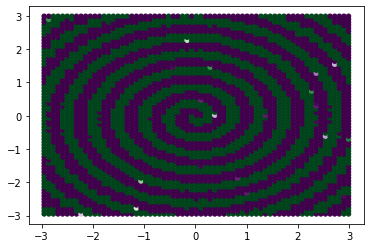

In [7]:
with open('clf/spiral_behavior.pickle', 'rb') as f:
    tempX, tempY, tempC = pickle.load(f, encoding='bytes')

plt.scatter(tempX, tempY, c=tempC, cmap='PRGn', s=20)

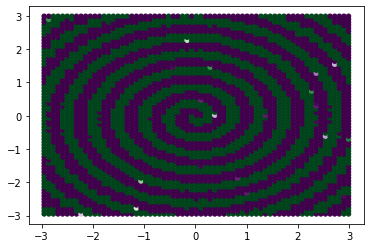

In [8]:
with open('clf/spiral.pickle', 'rb') as f:
    tempX, tempY, tempC = pickle.load(f, encoding='bytes')

plt.scatter(tempX, tempY, c=tempC, cmap='PRGn', s=20)

## It is imperative to make sure that two true spiral posteriors used for ML and human are identical
In the following, two spirals are overlaid where black and white scheme represents human posterior and color scheme for ML, and as can be seen, two sprials are in sync

Note: the human true posterior extends outside of the extrapolative region (ie unit circle). This is now subsequently accounted for when calculating hellinger distance

In [7]:
#re-generating true posteriors to match the size of the grid used for human
ib.get_posterior(h=0.1, rng=3)

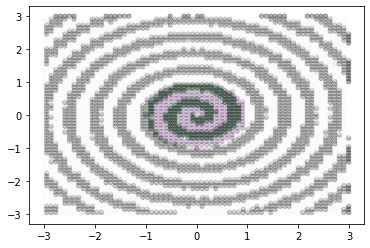

In [10]:
x,y,c = ib.truepst[1][2]

plt.scatter(tempX, tempY, c=tempC, cmap='Greys',s=20,alpha=0.3) #human true posterior
plt.scatter(x,y,c=c,cmap=cmap,s=20, alpha=0.2) #ML true posterior (outside 0.5)

## Re-evaluating human hellinger
As human true spiral posterior extends throughout extrapolative region, we need to recalculate hellinger distance after adjusting true posterior accordingly

Note: human true posterior is actively assigned at the time of behavioral experiment. Thus, each point is associated with both human estimate and its corresponding true posterior values. This is why true posterior seems discontinuous

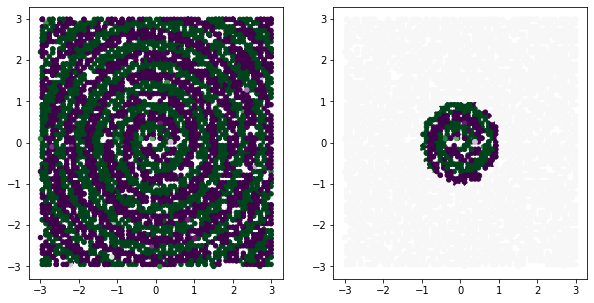

In [72]:
fig, axs = plt.subplots(1,2, figsize=(5*2,5))

temp = np.column_stack([ib.human[0][:,3], ib.human[0][:,5], ib.human[0][:,1]]).astype(float)
axs[0].scatter(temp[:,0],temp[:,1],c=ib.human[0][:,1],cmap=cmap, s=20)

ib.human[0][:,1] = np.where(ib._euclidean(temp) > 1, 0.5, temp[:,2])
axs[1].scatter(temp[:,0],temp[:,1],c=ib.human[0][:,1],cmap=cmap, s=20)

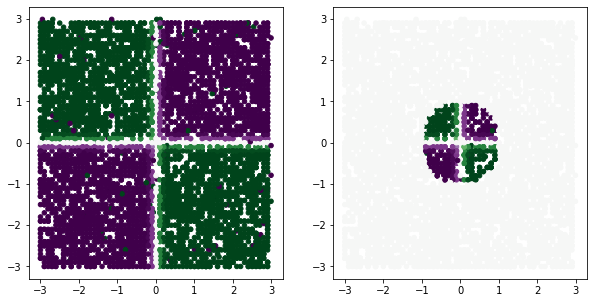

In [73]:
fig, axs = plt.subplots(1,2, figsize=(5*2,5))

temp = np.column_stack([ib.human[1][:,3], ib.human[1][:,5], ib.human[1][:,1]]).astype(float)
axs[0].scatter(temp[:,0],temp[:,1],c=ib.human[1][:,1],cmap=cmap, s=20)

ib.human[1][:,1] = np.where(ib._euclidean(temp) > 1, 0.5, temp[:,2])
axs[1].scatter(temp[:,0],temp[:,1],c=ib.human[1][:,1],cmap=cmap, s=20)

## Correcting human true posterior
Corrected true posteriors (ie reassigning posterior values outside of unit circle to 0.5) are pickled into the data to be read by `load_MTurk` method 

In [74]:
for i in range(2):
    ib.human[i] = np.delete(ib.human[i], 6, 1) #delete hellinger column for later repopulation

In [76]:
with open('dat/MTurk_ds.pickle', 'wb') as f:
    pickle.dump(np.concatenate([ib.human[0], ib.human[1]]), f)

In [77]:
ib.load_MTurk() #reloading MTurk data (this involves computation of hellinger distance within the method)

In [7]:
# sanity check to make sure human true posterior reflects the changes
temp = np.column_stack([ib.human[0][:,3], ib.human[0][:,5], ib.human[0][:,1]]).astype(float)
temp[ib._euclidean(temp) > 1]

array([[ 0.2 ,  1.19,  0.5 ],
       [-1.51, -1.15,  0.5 ],
       [-1.33,  2.27,  0.5 ],
       ...,
       [ 2.36, -0.34,  0.5 ],
       [ 2.54,  0.65,  0.5 ],
       [-2.05, -1.51,  0.5 ]])

## Re-train ML at lower sample size and sample 100 points for 126 iterations
This effectively simulates the experimental conditions of human behavioral experiment

In [8]:
uX.shape, reps, N_sample

((3600, 2), 126, 100)

In [25]:
# run only for the first time
# ib.get_sampledData(saved_clf=saved_clf, reps=reps, N_sample=N_sample, h=0.1, rng=3)

In [9]:
ib.load_sampledData()

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SampledData.pickle ] loaded


## Unsmoothed estimated posteriors for ML models and human

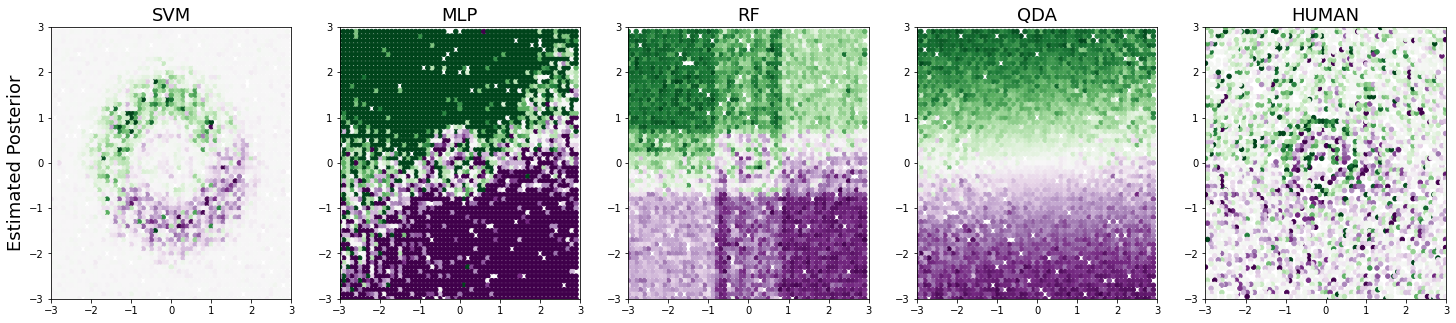

In [10]:
fig, axs = plt.subplots(1,5, figsize=(5*5,5))

for i, mod in enumerate(ib.mtype + ['HUMAN']):
    if i == 4:
        tempxy3 = ib.pointwise_gridAverage(np.column_stack([ib.human[0][:,3], ib.human[0][:,5], ib.human[0][:,0]]))
    else:
        tempxy3 = ib.pointwise_gridAverage(ib.estpst_sample[0][i][::1])

    axs[i].scatter(x=tempxy3['x'],y=tempxy3['y'],c=tempxy3['c'],s=20,cmap='PRGn')
    axs[i].set_title(mod,fontsize=fsize)
    axs[i].set_xlim([-3,3])
    axs[i].set_ylim([-3,3])
    axs[0].set_ylabel('Estimated Posterior',fontsize=fsize)
    plt.savefig(f'figs/[20210505_retrainML_lowerDensity]_averaged_126models_posterior_spiral_{str(ib.date.date())}.png', bbox_inches='tight')

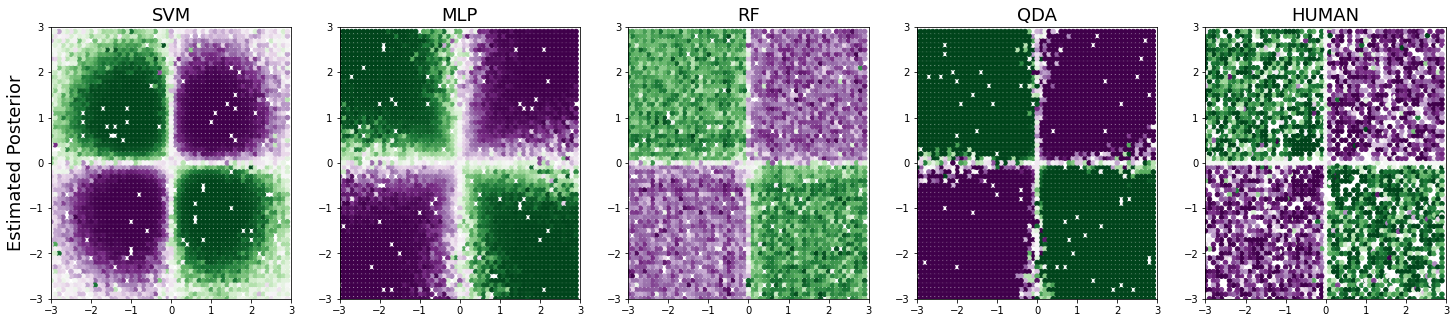

In [12]:
fig, axs = plt.subplots(1,5, figsize=(5*5,5))

for i, mod in enumerate(ib.mtype + ['HUMAN']):
    if i == 4:
        tempxy3 = ib.pointwise_gridAverage(np.column_stack([ib.human[1][:,3], ib.human[1][:,5], ib.human[1][:,0]]))
    else:
        tempxy3 = ib.pointwise_gridAverage(ib.estpst_sample[1][i][::1])

    axs[i].scatter(x=tempxy3['x'],y=tempxy3['y'],c=tempxy3['c'],s=20,cmap='PRGn')
    axs[i].set_title(mod,fontsize=fsize)
    axs[i].set_xlim([-3,3])
    axs[i].set_ylim([-3,3])
    axs[0].set_ylabel('Estimated Posterior',fontsize=fsize)
    plt.savefig(f'figs/[20210505_retrainML_lowerDensity]_averaged_126models_posterior_sxor_{str(ib.date.date())}.png', bbox_inches='tight')

## Unsmoothed hellinger distances for ML models and human

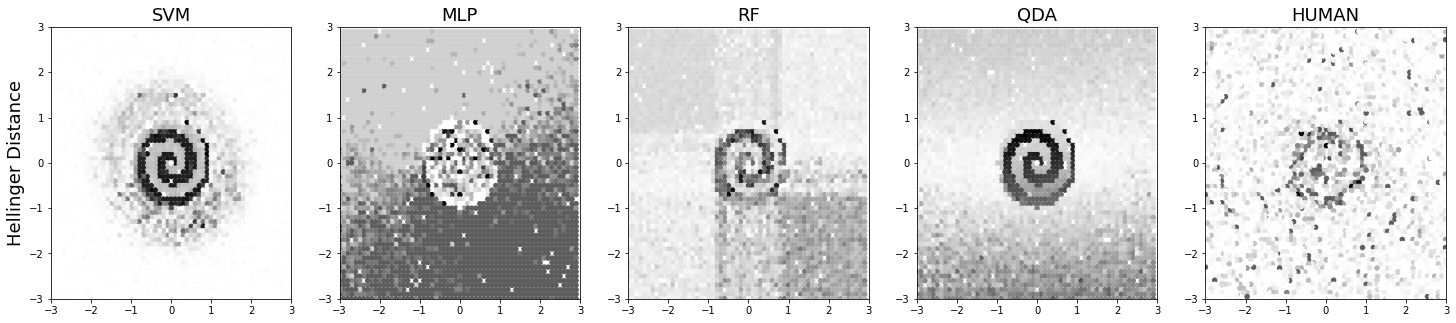

In [13]:
fig, axs = plt.subplots(1,5, figsize=(5*5,5))

for i, mod in enumerate(ib.mtype + ['HUMAN']):
    if i == 4:
        tempxy3 = ib.pointwise_gridAverage(np.column_stack([ib.human[0][:,3], ib.human[0][:,5], ib.human[0][:,6]]))
    else:
        tempxy3 = ib.pointwise_gridAverage(ib.hdist_sample[0][i][::1])

    axs[i].scatter(x=tempxy3['x'],y=tempxy3['y'],c=tempxy3['c'], s=20, cmap='Greys')
    axs[i].set_title(mod,fontsize=fsize)
    axs[i].set_xlim([-3,3])
    axs[i].set_ylim([-3,3])
    axs[0].set_ylabel('Hellinger Distance',fontsize=fsize)
    plt.savefig(f'figs/[20210505_retrainML_lowerDensity]_averaged_126models_hellinger_spiral_{str(ib.date.date())}.png', bbox_inches='tight')

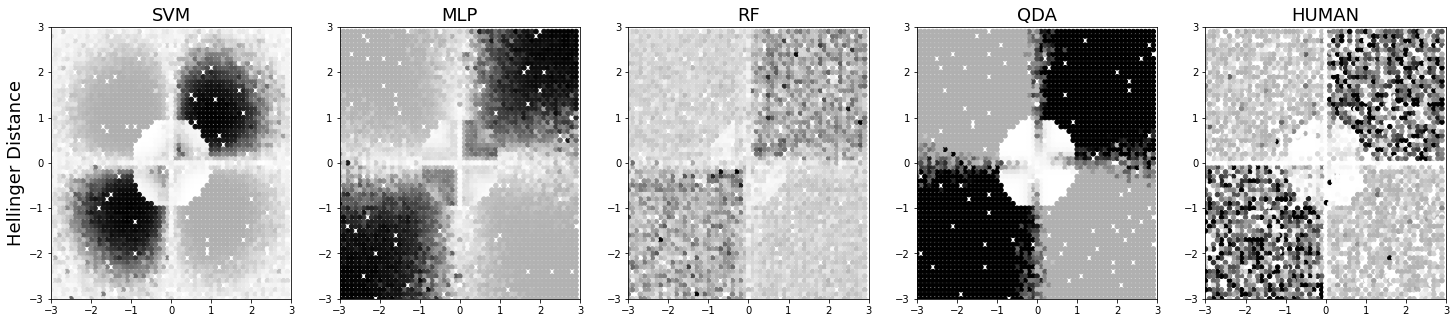

In [14]:
fig, axs = plt.subplots(1,5, figsize=(5*5,5))

for i, mod in enumerate(ib.mtype + ['HUMAN']):
    if i == 4:
        tempxy3 = ib.pointwise_gridAverage(np.column_stack([ib.human[1][:,3], ib.human[1][:,5], ib.human[1][:,6]]))
    else:
        tempxy3 = ib.pointwise_gridAverage(ib.hdist_sample[1][i][::1])

    axs[i].scatter(x=tempxy3['x'],y=tempxy3['y'],c=tempxy3['c'], s=20, cmap='Greys')
    axs[i].set_title(mod,fontsize=fsize)
    axs[i].set_xlim([-3,3])
    axs[i].set_ylim([-3,3])
    axs[0].set_ylabel('Hellinger Distance',fontsize=fsize)
    plt.savefig(f'figs/[20210505_retrainML_lowerDensity]_averaged_126models_hellinger_sxor_{str(ib.date.date())}.png', bbox_inches='tight')

## Smoothing power examination
Optimal parameter for gaussian smoothing was qualitatively determined

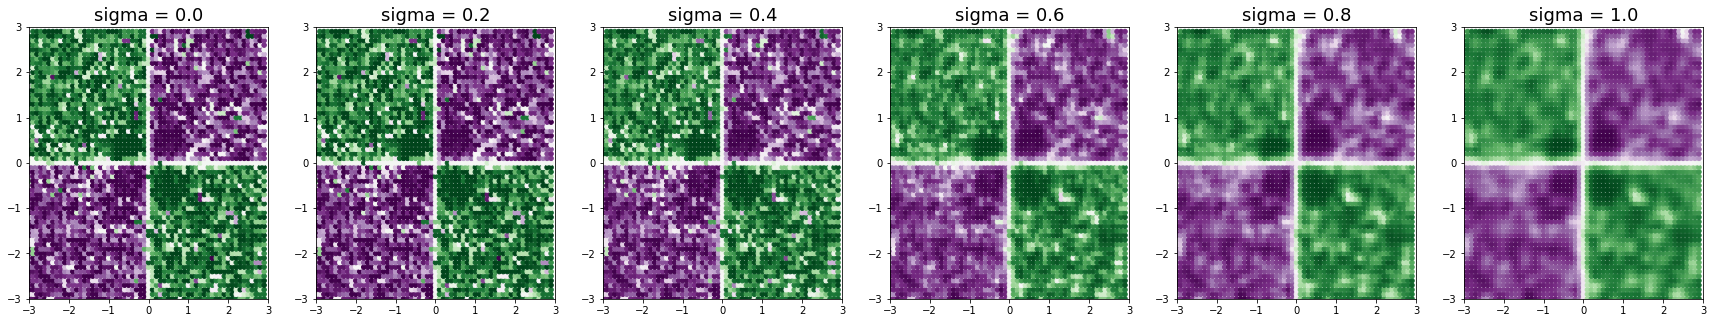

In [23]:
sigs = np.arange(0,1.2,0.2)

fig, axs = plt.subplots(1,len(sigs),figsize=(5*len(sigs),5))

for i, sig in enumerate(sigs):
    mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()
    xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method=None, sigma=sig, k=10)
    axs[i].scatter(x=np.array(xy)[:,0], y=np.array(xy)[:,1], c=alls, cmap=cmap, s=20)  
    axs[i].set_xlim([-3,3])
    axs[i].set_ylim([-3,3])
    axs[i].set_title(f'sigma = {round(sig,1)}', fontsize=18)

plt.savefig(f'figs/[20210505_retrainML_lowerDensity]_gaussian_sigma.png', bbox_inches='tight')

## Generating the collective figure _without_ convolution
This yields the same size grid (ie the same grid used for human) and uses a single k-nearest neighbor (k=1) for interpolation of missing points. This is followed by gaussian smoothing (sigma=1)

Wall time: 34.6 s


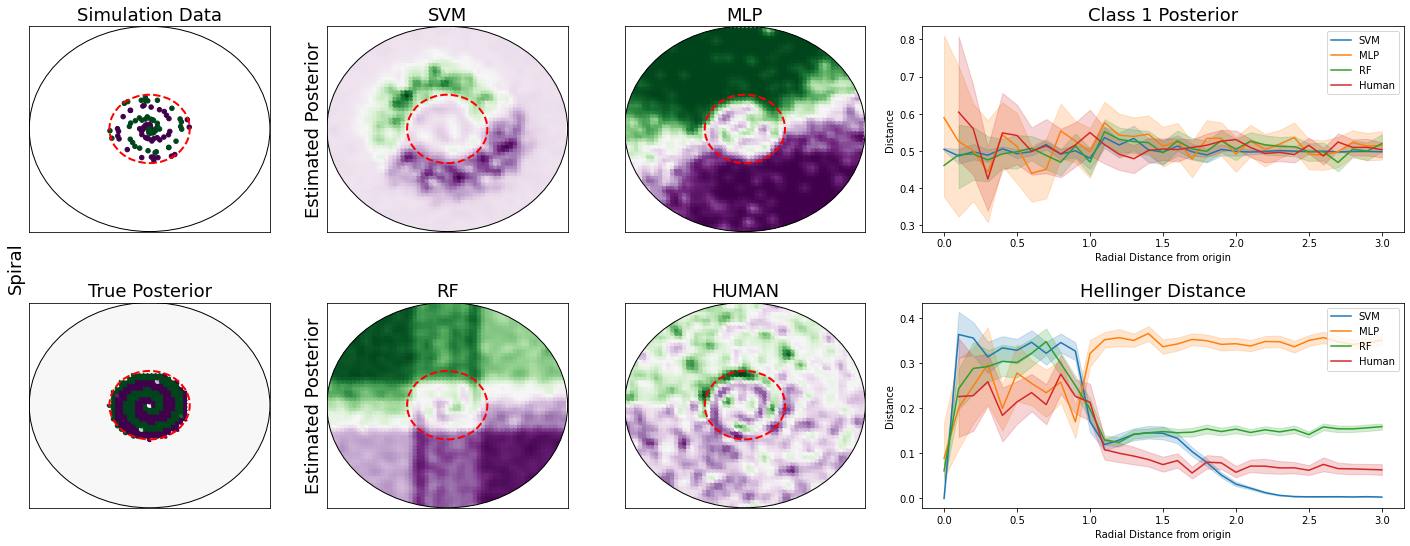

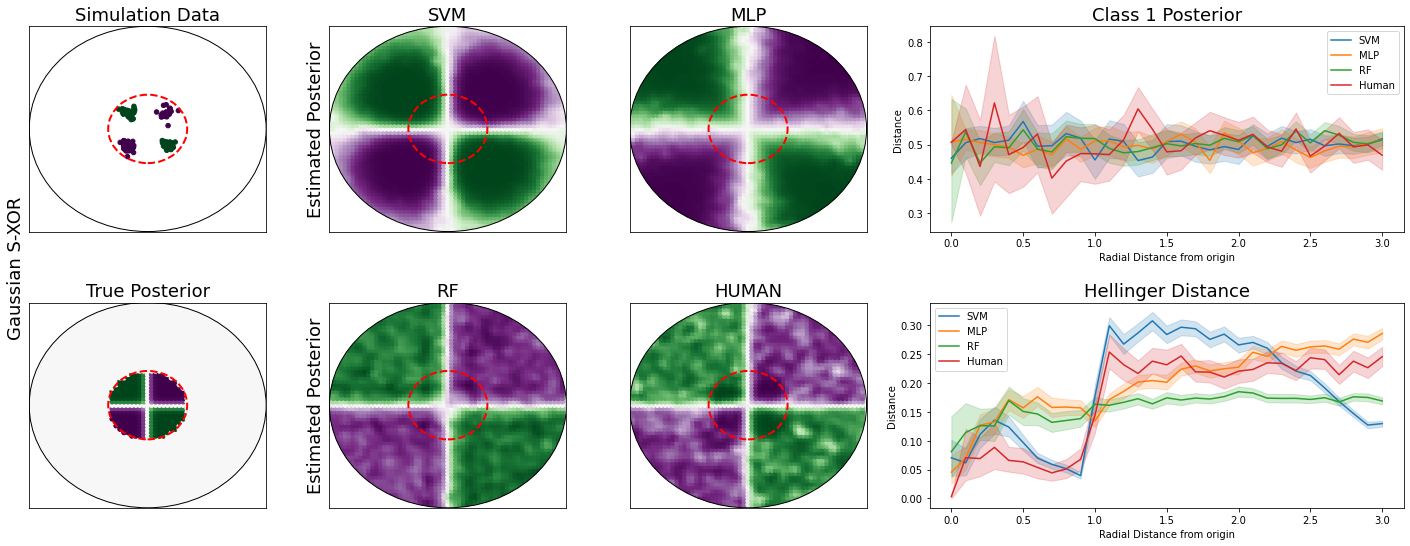

In [24]:
%%time
'''
This figure contains simulation data at idx[0,0], true posterior at idx[1,0], 
estimated posterior at idx[i=1,2|j=1,2], class 1 posterior at idx[0,3], and hellinger distance at idx[1,3]
'''
row = 2
col = 4
interp_method = 'linear'  # interpolation methods
fname = ['spiral', 'sxor']

for ii, j in enumerate([2, 4]):

    cnt = 0

    widths = [4, 4, 4, 8]
    fig = plt.figure(figsize=(4*(col+1), 4*row))
    spec = fig.add_gridspec(ncols=col, nrows=row, width_ratios=widths)

    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')

    ax.set_ylabel(ib.dtype[j], fontsize=18)

    for k in range(row):
        for i in range(col):
            cnt += 1

            axs = fig.add_subplot(spec[k, i])

            # simulation dataset
            if cnt == 1:
                pcm = axs.scatter(ib.train_X[j][:,0], ib.train_X[j][:,1], c=ib.train_y[j], cmap=cmap, s=20)

            # true posterior
            elif cnt == 5:
                xx = ib.truepst[1][j][0]
                yy = ib.truepst[1][j][1]
                cc = ib.truepst[1][j][2]
                pcm = axs.scatter(xx, yy, c=cc, cmap=cmap, s=20)

            elif cnt in [2,3,6,7]:
                # estimated posterior (SVM)
                if cnt == 2:
                    mtype_i = ib.estpst_sample[ii][0]
                    axs.set_title(ib.mtype[0], fontsize=fsize)
                # estimated posterior (MLP)
                elif cnt == 3:
                    mtype_i = ib.estpst_sample[ii][1]
                    axs.set_title(ib.mtype[1], fontsize=fsize)
                # estimated posterior (RF)
                elif cnt == 6:
                    mtype_i = ib.estpst_sample[ii][2]
                    axs.set_title(ib.mtype[2], fontsize=fsize)
                # human estimates
                elif cnt == 7:
                    mtype_i = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5], ib.human[ii][:,0]])    
                    axs.set_title('HUMAN', fontsize=fsize)

                mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()
                xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method=None, sigma=1, k=10)
                pcm = axs.scatter(x=np.array(xy)[:,0], y=np.array(xy)[:,1], c=alls, cmap=cmap, s=20)             

            # radial plot
            elif cnt in [4,8]:
                for i in range(4):                    
                    if i == 3:        
                        hmask = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5]])
                        if cnt == 4:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,0]]).astype(float))
                        elif cnt == 8:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,6]]).astype(float))
                    else:
                        if cnt == 4:
                            temp = ib.get_radialDist(ib.estpst_sample[ii][i])
                        elif cnt == 8:
                            temp = ib.get_radialDist(ib.hdist_sample[ii][i])

                    temp2 = pd.DataFrame(temp[1]).T
                    temp2.columns = temp[0]
                    temp2 = temp2.melt().dropna()
                    temp2.columns=['Radial Distance from origin', 'Distance']
                    sns.lineplot(data=temp2, x=temp2.columns[0], y=temp2.columns[1], ci=95, label=label[i], ax=axs)
            
            ## figure styling ##
            if cnt != 4 and cnt != 8:                
                circle = Circle((0, 0), 3, linewidth=1, edgecolor='k', facecolor='none') # outer bounding circle                
                axs.add_patch(Circle((0, 0), radius=1, linewidth=2, ls='--', edgecolor='r', fill=False)) # inner unit circle                
                axs.add_patch(circle)
                pcm.set_clip_path(circle)

                axs.set_xlim([-3, 3])
                axs.set_ylim([-3, 3])

            if k == 0 and i == 0:
                axs.set_title('Simulation Data', fontsize=fsize)

            if k == 1 and i == 0:
                axs.set_title('True Posterior', fontsize=fsize)

            if k == 0 and i == 3:
                axs.set_title('Class 1 Posterior', fontsize=fsize)

            if k == 1 and i == 3:
                axs.set_title('Hellinger Distance', fontsize=fsize)

            if i == 1 and (k == 0 or k == 1):
                axs.set_ylabel('Estimated Posterior', fontsize=fsize)

            if i < 3:
                axs.set_xticks([])
                axs.set_yticks([])

    plt.tight_layout(pad=2)
    plt.savefig(f'figs/[20210505_retrainML_lowerDensity]_model_human_figure_{fname[ii]}_{str(ib.date.date())}_noconv.png', bbox_inches='tight')

## Generating the collective figure _with_ convolution
This yields smaller grid and uses averaging of k-nearest neighbors (k=10). This is followed by gaussian smoothing (sigma=1)

Wall time: 20min 39s


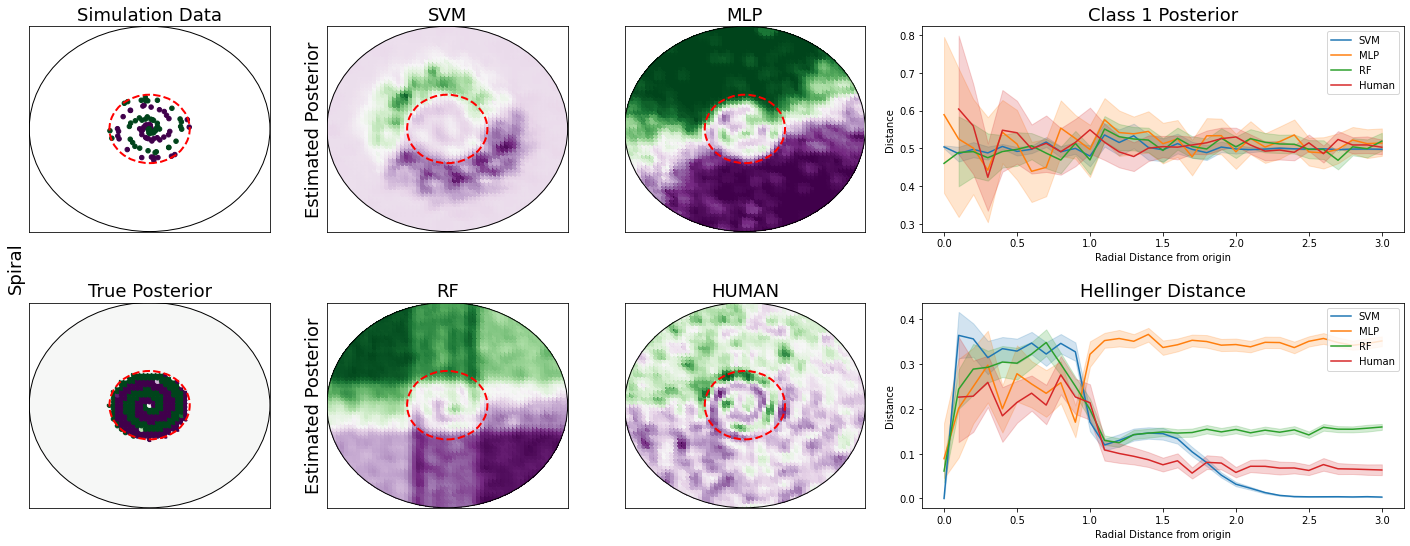

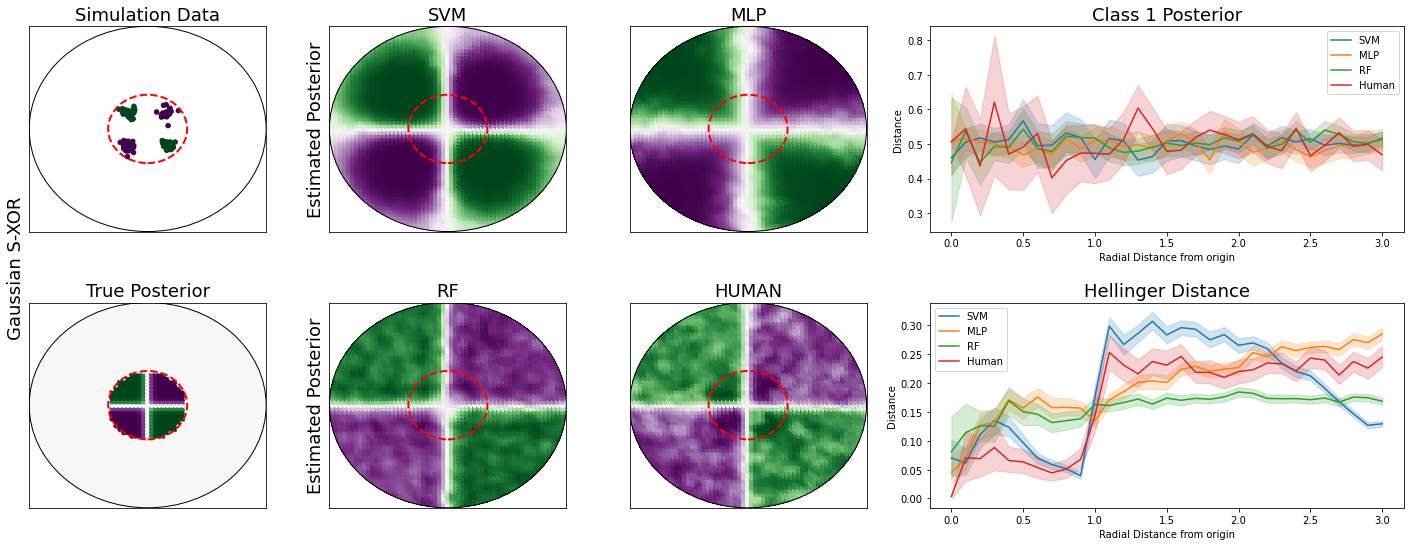

In [13]:
%%time
'''
This figure contains simulation data at idx[0,0], true posterior at idx[1,0], 
estimated posterior at idx[i=1,2|j=1,2], class 1 posterior at idx[0,3], and hellinger distance at idx[1,3]
'''
row = 2
col = 4
interp_method = 'linear'  # interpolation methods
fname = ['spiral', 'sxor']

for ii, j in enumerate([2, 4]):

    cnt = 0

    widths = [4, 4, 4, 8]
    fig = plt.figure(figsize=(4*(col+1), 4*row))
    spec = fig.add_gridspec(ncols=col, nrows=row, width_ratios=widths)

    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')

    ax.set_ylabel(ib.dtype[j], fontsize=18)

    for k in range(row):
        for i in range(col):
            cnt += 1

            axs = fig.add_subplot(spec[k, i])

            # simulation dataset
            if cnt == 1:
                pcm = axs.scatter(ib.train_X[j][:,0], ib.train_X[j][:,1], c=ib.train_y[j], cmap=cmap, s=20)

            # true posterior
            elif cnt == 5:
                xx = ib.truepst[1][j][0]
                yy = ib.truepst[1][j][1]
                cc = ib.truepst[1][j][2]
                pcm = axs.scatter(xx, yy, c=cc, cmap=cmap, s=20)

            elif cnt in [2,3,6,7]:
                # estimated posterior (SVM)
                if cnt == 2:
                    mtype_i = ib.estpst_sample[ii][0]
                    axs.set_title(ib.mtype[0], fontsize=fsize)
                # estimated posterior (MLP)
                elif cnt == 3:
                    mtype_i = ib.estpst_sample[ii][1]
                    axs.set_title(ib.mtype[1], fontsize=fsize)
                # estimated posterior (RF)
                elif cnt == 6:
                    mtype_i = ib.estpst_sample[ii][2]
                    axs.set_title(ib.mtype[2], fontsize=fsize)
                # human estimates
                elif cnt == 7:
                    mtype_i = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5], ib.human[ii][:,0]])    
                    axs.set_title('HUMAN', fontsize=fsize)

                mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()
                xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method='mean', sigma=1, k=10)
                pcm = axs.scatter(x=np.array(xy)[:,0], y=np.array(xy)[:,1], c=alls, cmap=cmap, s=20)             

            # radial plot
            elif cnt in [4,8]:
                for i in range(4):                    
                    if i == 3:        
                        hmask = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5]])
                        if cnt == 4:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,0]]).astype(float))
                        elif cnt == 8:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,6]]).astype(float))
                    else:
                        if cnt == 4:
                            temp = ib.get_radialDist(ib.estpst_sample[ii][i])
                        elif cnt == 8:
                            temp = ib.get_radialDist(ib.hdist_sample[ii][i])

                    temp2 = pd.DataFrame(temp[1]).T
                    temp2.columns = temp[0]
                    temp2 = temp2.melt().dropna()
                    temp2.columns=['Radial Distance from origin', 'Distance']
                    sns.lineplot(data=temp2, x=temp2.columns[0], y=temp2.columns[1], ci=95, label=label[i], ax=axs)
            
            ## figure styling ##
            if cnt != 4 and cnt != 8:                
                circle = Circle((0, 0), 3, linewidth=1, edgecolor='k', facecolor='none') # outer bounding circle                
                axs.add_patch(Circle((0, 0), radius=1, linewidth=2, ls='--', edgecolor='r', fill=False)) # inner unit circle                
                axs.add_patch(circle)
                pcm.set_clip_path(circle)

                axs.set_xlim([-3, 3])
                axs.set_ylim([-3, 3])

            if k == 0 and i == 0:
                axs.set_title('Simulation Data', fontsize=fsize)

            if k == 1 and i == 0:
                axs.set_title('True Posterior', fontsize=fsize)

            if k == 0 and i == 3:
                axs.set_title('Class 1 Posterior', fontsize=fsize)

            if k == 1 and i == 3:
                axs.set_title('Hellinger Distance', fontsize=fsize)

            if i == 1 and (k == 0 or k == 1):
                axs.set_ylabel('Estimated Posterior', fontsize=fsize)

            if i < 3:
                axs.set_xticks([])
                axs.set_yticks([])

    plt.tight_layout(pad=2)
    plt.savefig(f'figs/[20210505_retrainML_lowerDensity]_model_human_figure_{fname[ii]}_{str(ib.date.date())}.png', bbox_inches='tight')